# Makam pitch sequence classification with LSTM

### Library importing for file reading and preprocessing

### Preprocessing pitch files

Before proceeding, the pitch files on the CompMusic Dunya makam corpus need to be converted in the quantized pitch series encoding constructed as described in quantizedencoding.py script.

In [2]:
import glob
import os
import sys
import json
import numpy as np
import dill
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### File reading, octave folded encoding

In [13]:
#Makam list
makams = ["Acemasiran", "Acemkurdi", "Bestenigar", "Beyati", "Hicaz", "Hicazkar", "Huseyni", "Huzzam", "Karcigar", "Kurdilihicazkar", "Mahur", "Muhayyer", "Neva", "Nihavent", "Rast", "Saba", "Segah", "Sultaniyegah", "Suzinak", "Ussak"]

#Arrays containing all constant-Q transforms of the soundfiles per fold
pitch = [[],[],[],[],[],[],[],[],[],[]]

#Array containing all makam labels per fold
y_train = [[],[],[],[],[],[],[],[],[],[]]
y_test = [[],[],[],[],[],[],[],[],[],[]]

#Import folds
f = open("./dlfm_makam_recognition_data/folds_updated.json")
folds = json.load(f)


#Import all quantized pitch files and their labels
for i in range(len(folds)): #in number of folds
    
    print("\nLoading fold " + str(i) + ".")
    
    #import all training series and labels
    for source in range(len(folds[i][1]["training"]["sources"])):
        
        file_name = ("./qdata/" + folds[i][1]["training"]["sources"][source] + ".pitch")
        
        with open(file_name) as f:
            content = f.read()
            pitch[i].append(content)
        
        #import makam training label
        y_train[i].append(makams.index(folds[i][1]["training"]["modes"][source]))
        
        sys.stdout.write("\rLoading training %i/900" % (source+1))
        sys.stdout.flush()
        
    print()
    
    #import all testing series and labels
    for ref in range(len(folds[i][1]["testing"])):
        
        file_name = ("./qdata/" + folds[i][1]["testing"][ref]["source"] + ".pitch")
        
        with open(file_name) as f:
            content = f.read()
            pitch[i].append(content)
            
        #import makam testing label
        y_test[i].append(makams.index(folds[i][1]["testing"][ref]["mode"]))

        sys.stdout.write("\rLoading testing %i/100" % (ref+1))
        sys.stdout.flush()
        
 

print("Pitch shape:", len(pitch), len(pitch))
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_test))

f.close()


Loading fold 0.
Loading training 900/900
Loading testing 100/100
Loading fold 1.
Loading training 900/900
Loading testing 100/100
Loading fold 2.
Loading training 900/900
Loading testing 100/100
Loading fold 3.
Loading training 900/900
Loading testing 100/100
Loading fold 4.
Loading training 900/900
Loading testing 100/100
Loading fold 5.
Loading training 900/900
Loading testing 100/100
Loading fold 6.
Loading training 900/900
Loading testing 100/100
Loading fold 7.
Loading training 900/900
Loading testing 100/100
Loading fold 8.
Loading training 900/900
Loading testing 100/100
Loading fold 9.
Loading training 900/900
Loading testing 100/100
Fold loading completed.
Pitch shape: 10 10
y_train shape: 10
y_test shape: 10


### Preprocessing
Pading input sequences

In [16]:
#Tokenization
top_k = 500
seqs = []
for i in range(len(folds)):
    tokenizer = Tokenizer(num_words=top_k, filters='', split='\n')
    tokenizer.fit_on_texts(pitch[i])
    seqs.append(tokenizer.texts_to_sequences(pitch[i]))
print(len(seqs))

10


In [17]:
#Padding
maxlen = 10000 #select maximum sequence length
X = []
for i in range(len(folds)):
    X.append(sequence.pad_sequences(np.asarray(seqs[i]), maxlen = maxlen, padding='post'))

print(X[1][0:100])

[[178 138 252 ...  58  39  58]
 [  6   9  22 ...  50  68  50]
 [ 38  45  38 ...   1  42  49]
 ...
 [ 38  45  15 ...  21  37  19]
 [ 14  24  14 ... 298 325 298]
 [122 277 122 ...   0   0   0]]


### Library importing for deep learning

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

### Data preparation

In [26]:
X_train = []
X_test = []
for i in range(len(folds)):
    X_train.append(np.asarray(X[i][:900]))
    X_test.append(np.asarray(X[i][900:1000]))
print(len(X_train), len(X_train[0]))
print(len(X_test), len(X_test[0]))

Y_train = to_categorical(np.asarray(y_train))
Y_test = to_categorical(np.asarray(y_test))
print(len(Y_train), len(Y_train[0]))
print(len(Y_test), len(Y_train[0]))

10 900
10 100
10 900
10 900


### Building the LSTM

In [21]:
models = []
for i in range(len(folds)):
    #Network topology
    model = Sequential()

    #model.add(Embedding(top_k, embedding_vector_len, input_length=len(X[0])))
    model.add(Embedding(500, 64, input_length=10000)) #smaller input length for testing
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='softmax'))
    
    #Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'], )
    model.summary()

    models.append(model)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 10000, 64)         32000     
_________________________________________________________________
dropout_61 (Dropout)         (None, 10000, 64)         0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                2020      
Total params: 100,020
Trainable params: 100,020
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
Layer (type)            

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 10000, 64)         32000     
_________________________________________________________________
dropout_79 (Dropout)         (None, 10000, 64)         0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dropout_80 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 20)                2020      
Total params: 100,020
Trainable params: 100,020
Non-trainable params: 0
_________________________________________________________________


In [23]:
histories = []
for i in range(len(folds)):
    history = models[i].fit(X_train[i], np.asarray(y_train[i]), validation_split=0.25, epochs=50, batch_size=32)
    histories.append(history)

Train on 675 samples, validate on 225 samples
Epoch 1/50
675/675 [==============================] - 258s 383ms/step - loss: 2.9249 - accuracy: 0.0800 - val_loss: 5.0950 - val_accuracy: 0.0000e+00
Epoch 2/50
675/675 [==============================] - 260s 385ms/step - loss: 2.7624 - accuracy: 0.0652 - val_loss: 5.6757 - val_accuracy: 0.0000e+00
Epoch 3/50
675/675 [==============================] - 261s 386ms/step - loss: 2.7477 - accuracy: 0.0593 - val_loss: 6.0062 - val_accuracy: 0.0000e+00
Epoch 4/50
675/675 [==============================] - 261s 386ms/step - loss: 2.7221 - accuracy: 0.0756 - val_loss: 6.1255 - val_accuracy: 0.0000e+00
Epoch 5/50
675/675 [==============================] - 260s 385ms/step - loss: 2.7039 - accuracy: 0.0756 - val_loss: 6.1617 - val_accuracy: 0.0000e+00
Epoch 6/50
675/675 [==============================] - 260s 384ms/step - loss: 2.6647 - accuracy: 0.1200 - val_loss: 5.7639 - val_accuracy: 0.0000e+00
Epoch 7/50
675/675 [==============================] - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 675 samples, validate on 225 samples
Epoch 1/50
675/675 [==============================] - 251s 372ms/step - loss: 2.9664 - accuracy: 0.0726 - val_loss: 4.7095 - val_accuracy: 0.0000e+00
Epoch 2/50
675/675 [==============================] - 260s 386ms/step - loss: 2.7821 - accuracy: 0.0533 - val_loss: 6.0653 - val_accuracy: 0.0000e+00
Epoch 3/50
675/675 [==============================] - 259s 384ms/step - loss: 2.7399 - accuracy: 0.0578 - val_loss: 6.4075 - val_accuracy: 0.0000e+00
Epoch 4/50
675/675 [==============================] - 259s 384ms/step - loss: 2.7435 - accuracy: 0.0489 - val_loss: 6.5802 - val_accuracy: 0.0000e+00
Epoch 5/50
675/675 [==============================] - 259s 384ms/step - loss: 2.7198 - accuracy: 0.0756 - val_loss: 6.4517 - val_accuracy: 0.0000e+00
Epoch 6/50
352/675 [==============>...............] - ETA: 1:56 - loss: 2.6944 - accuracy: 0.0994

KeyboardInterrupt: 

In [24]:
#Model evaluation
scores = []
y_pred = [[],[],[],[],[],[],[],[],[],[]]
for i in range(1):
    scores.append(model.evaluate(X_test[i], np.asarray(y_test[i]), verbose=1))
    y_pred[i].append(model.predict(X_test[i], verbose=1))
print(scores)

100/100 [==============================] - 4s 41ms/step
[[2.997562065124512, 0.05000000074505806]]


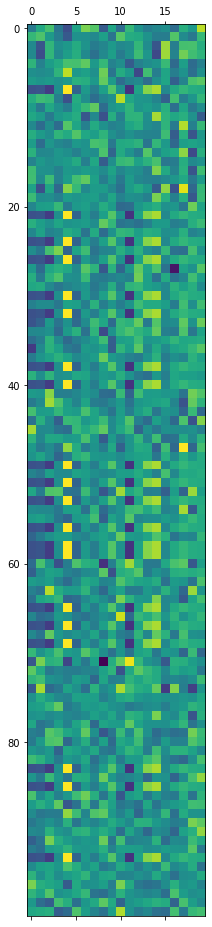

In [43]:
plt.matshow(y_pred[0][0])
plt.show()

In [ ]:
dill.dump_session('LSTM10foldssparsecateg')

In [3]:
dill.load_session('LSTM10folds')

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: 

[[0.04947704 0.05030086 0.05072093 ... 0.05040561 0.05001444 0.05154279]
 [0.05056487 0.05079577 0.05004486 ... 0.04977895 0.04945884 0.05057278]
 [0.04974943 0.04885765 0.05053457 ... 0.05073609 0.05074107 0.05038214]
 ...
 [0.05051605 0.05017499 0.05082397 ... 0.05007803 0.04983108 0.04991382]
 [0.04999694 0.04925345 0.04901185 ... 0.05074815 0.05010294 0.0497281 ]
 [0.05028688 0.05034536 0.05041906 ... 0.04948652 0.05057462 0.05070026]]


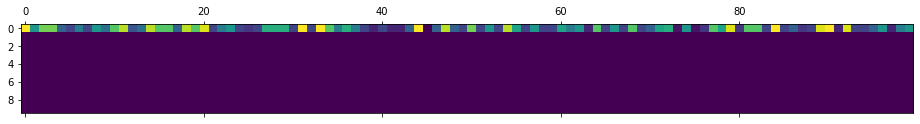

In [44]:
confusion_matrix = np.zeros((20,20), dtype=np.intc)
original_class = np.zeros((10,100), dtype=np.intc)
predicted_class = np.zeros((10,100), dtype=np.intc)
print(y_pred[0][0])
for fold in range(1):
    for piece in range(100): 
        
        original_class[fold][piece] = y_test[fold][piece]


for fold in range(1):
    for piece in range(100): 
        predicted_class[fold][piece] = np.argmax(y_pred[0][fold][piece])
        
for fold in range(1):
    for piece in range(100):
        confusion_matrix[(predicted_class[fold][piece])][(original_class[fold][piece])] += 1

plt.matshow(predicted_class)
plt.show()

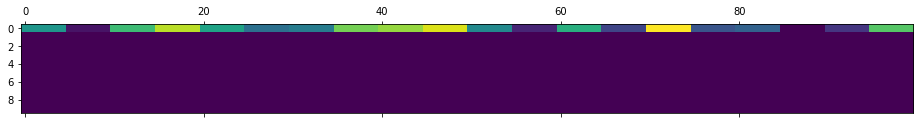

In [45]:
plt.matshow(original_class)
plt.show()


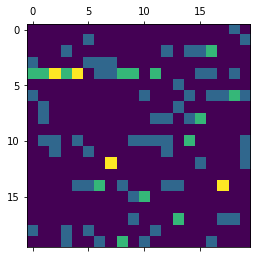

In [46]:
plt.matshow(confusion_matrix)
plt.show()